In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='pandas')

# Load dataset
df1 = pd.read_csv("dataset/kigali_real_estate_prices.csv")
df1.shape  # Check the size of the dataset
df1.head()  # Display the first few rows




,Location,Property_Type,Size_sqm,Number_of_Bedrooms,Number_of_Bathrooms,Number_of_Floors,Year_Built,Parking_Space,Furnished,Proximity_to_City_Center_km,Proximity_to_Schools_km,Security_Features,Price_RWF
0,Kibagabaga,Bungalow,170,1,2,1,2018,1,1,6.053400,1.211984,1,3545686
1,Kacyiru,Bungalow,190,2,3,1,2003,0,0,8.048860,2.283878,1,5191761
2,Kanombe,Apartment,79,4,3,1,2011,0,0,2.917929,0.416259,1,3295061
3,Remera,Villa,174,3,3,1,1989,1,0,4.955305,3.478307,1,3488814
4,Kibagabaga,House,240,3,2,3,1990,0,0,8.438079,1.543986,1,6133847


In [2]:
# Check for missing values
df1.isnull().sum()



Location                       0
Property_Type                  0
Size_sqm                       0
Number_of_Bedrooms             0
Number_of_Bathrooms            0
Number_of_Floors               0
Year_Built                     0
Parking_Space                  0
Furnished                      0
Proximity_to_City_Center_km    0
Proximity_to_Schools_km        0
Security_Features              0
Price_RWF                      0
dtype: int64

In [3]:
# Remove leading/trailing whitespace in 'Location'
df1['Location'] = df1['Location'].apply(lambda x: x.strip())

# Check unique locations and property types
print(df1['Location'].unique())
print(df1['Property_Type'].unique())


['Kibagabaga' 'Kacyiru' 'Kanombe' 'Remera' 'Nyamirambo' 'Gacuriro'
 'Kimironko' 'Nyarutarama' 'Kicukiro']
['Bungalow' 'Apartment' 'Villa' 'House']


In [4]:

# Handle locations that occur fewer than 10 times
location_stats = df1.groupby('Location')['Location'].agg('count').sort_values(ascending=False)
location_stats_less_than_10 = location_stats[location_stats < 10]
df1['Location'] = df1['Location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

# Handle records with Year_Built < 1990
df1 = df1[~(df1.Year_Built < 1990)]

# Create a new column for price per square meter
df1['price_per_sqm'] = df1['Price_RWF'] / df1['Size_sqm']

In [5]:
def remove_location_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('Location'):
        mean = np.mean(subdf.price_per_sqm)
        std_dev = np.std(subdf.price_per_sqm)
        reduced_df = subdf[(subdf.price_per_sqm > (mean - std_dev)) & (subdf.price_per_sqm <= (mean + std_dev))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

df_cleaned = remove_location_outliers(df1)
df_cleaned


,Location,Property_Type,Size_sqm,Number_of_Bedrooms,Number_of_Bathrooms,Number_of_Floors,Year_Built,Parking_Space,Furnished,Proximity_to_City_Center_km,Proximity_to_Schools_km,Security_Features,Price_RWF,price_per_sqm
0,Gacuriro,Villa,149,4,2,3,2015,1,1,2.929362,1.466844,1,4019396,26975.812081
1,Gacuriro,Bungalow,214,2,2,3,2009,1,1,0.969455,1.283705,1,5488265,25646.098131
2,Gacuriro,Bungalow,135,3,2,1,2014,0,0,5.106890,1.952470,1,6448699,47768.140741
3,Gacuriro,Bungalow,109,5,1,1,1997,1,1,4.830527,0.000000,0,2097434,19242.513761
4,Gacuriro,Bungalow,98,5,2,2,2002,1,0,3.123421,0.682185,1,3088646,31516.795918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11834,Remera,Villa,193,3,3,3,1992,1,1,2.753904,2.679755,1,4774224,24736.911917
11835,Remera,Bungalow,191,5,1,2,1998,1,0,10.476284,0.938703,1,5345439,27986.591623
11836,Remera,House,167,2,3,3,1996,0,0,1.702134,1.116884,1,5994209,35893.467066
11837,Remera,House,221,3,3,2,2010,1,0,5.758835,2.229548,1,4165359,18847.778281


In [6]:
# One-hot encoding for Location
location_dummies = pd.get_dummies(df_cleaned['Location'], drop_first=True)
# One-hot encoding for Property_Type
property_dummies = pd.get_dummies(df_cleaned['Property_Type'], drop_first=True)

# Concatenate the encoded columns with the original dataframe
df_encoded = pd.concat([df_cleaned, location_dummies, property_dummies], axis=1)

# Drop the original 'Location' and 'Property_Type' columns
df_final = df_encoded.drop(['Location', 'Property_Type'], axis=1)


In [7]:
location_dummies

,Kacyiru,Kanombe,Kibagabaga,Kicukiro,Kimironko,Nyamirambo,Nyarutarama,Remera
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
11834,False,False,False,False,False,False,False,True
11835,False,False,False,False,False,False,False,True
11836,False,False,False,False,False,False,False,True
11837,False,False,False,False,False,False,False,True


In [8]:
property_dummies

,Bungalow,House,Villa
0,False,False,True
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
11834,False,False,True
11835,True,False,False
11836,False,True,False
11837,False,True,False


In [9]:
df_encoded

,Location,Property_Type,Size_sqm,Number_of_Bedrooms,Number_of_Bathrooms,Number_of_Floors,Year_Built,Parking_Space,Furnished,Proximity_to_City_Center_km,...,Kanombe,Kibagabaga,Kicukiro,Kimironko,Nyamirambo,Nyarutarama,Remera,Bungalow,House,Villa
0,Gacuriro,Villa,149,4,2,3,2015,1,1,2.929362,...,False,False,False,False,False,False,False,False,False,True
1,Gacuriro,Bungalow,214,2,2,3,2009,1,1,0.969455,...,False,False,False,False,False,False,False,True,False,False
2,Gacuriro,Bungalow,135,3,2,1,2014,0,0,5.106890,...,False,False,False,False,False,False,False,True,False,False
3,Gacuriro,Bungalow,109,5,1,1,1997,1,1,4.830527,...,False,False,False,False,False,False,False,True,False,False
4,Gacuriro,Bungalow,98,5,2,2,2002,1,0,3.123421,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11834,Remera,Villa,193,3,3,3,1992,1,1,2.753904,...,False,False,False,False,False,False,True,False,False,True
11835,Remera,Bungalow,191,5,1,2,1998,1,0,10.476284,...,False,False,False,False,False,False,True,True,False,False
11836,Remera,House,167,2,3,3,1996,0,0,1.702134,...,False,False,False,False,False,False,True,False,True,False
11837,Remera,House,221,3,3,2,2010,1,0,5.758835,...,False,False,False,False,False,False,True,False,True,False


In [10]:
df_final

,Size_sqm,Number_of_Bedrooms,Number_of_Bathrooms,Number_of_Floors,Year_Built,Parking_Space,Furnished,Proximity_to_City_Center_km,Proximity_to_Schools_km,Security_Features,...,Kanombe,Kibagabaga,Kicukiro,Kimironko,Nyamirambo,Nyarutarama,Remera,Bungalow,House,Villa
0,149,4,2,3,2015,1,1,2.929362,1.466844,1,...,False,False,False,False,False,False,False,False,False,True
1,214,2,2,3,2009,1,1,0.969455,1.283705,1,...,False,False,False,False,False,False,False,True,False,False
2,135,3,2,1,2014,0,0,5.106890,1.952470,1,...,False,False,False,False,False,False,False,True,False,False
3,109,5,1,1,1997,1,1,4.830527,0.000000,0,...,False,False,False,False,False,False,False,True,False,False
4,98,5,2,2,2002,1,0,3.123421,0.682185,1,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11834,193,3,3,3,1992,1,1,2.753904,2.679755,1,...,False,False,False,False,False,False,True,False,False,True
11835,191,5,1,2,1998,1,0,10.476284,0.938703,1,...,False,False,False,False,False,False,True,True,False,False
11836,167,2,3,3,1996,0,0,1.702134,1.116884,1,...,False,False,False,False,False,False,True,False,True,False
11837,221,3,3,2,2010,1,0,5.758835,2.229548,1,...,False,False,False,False,False,False,True,False,True,False


EDA

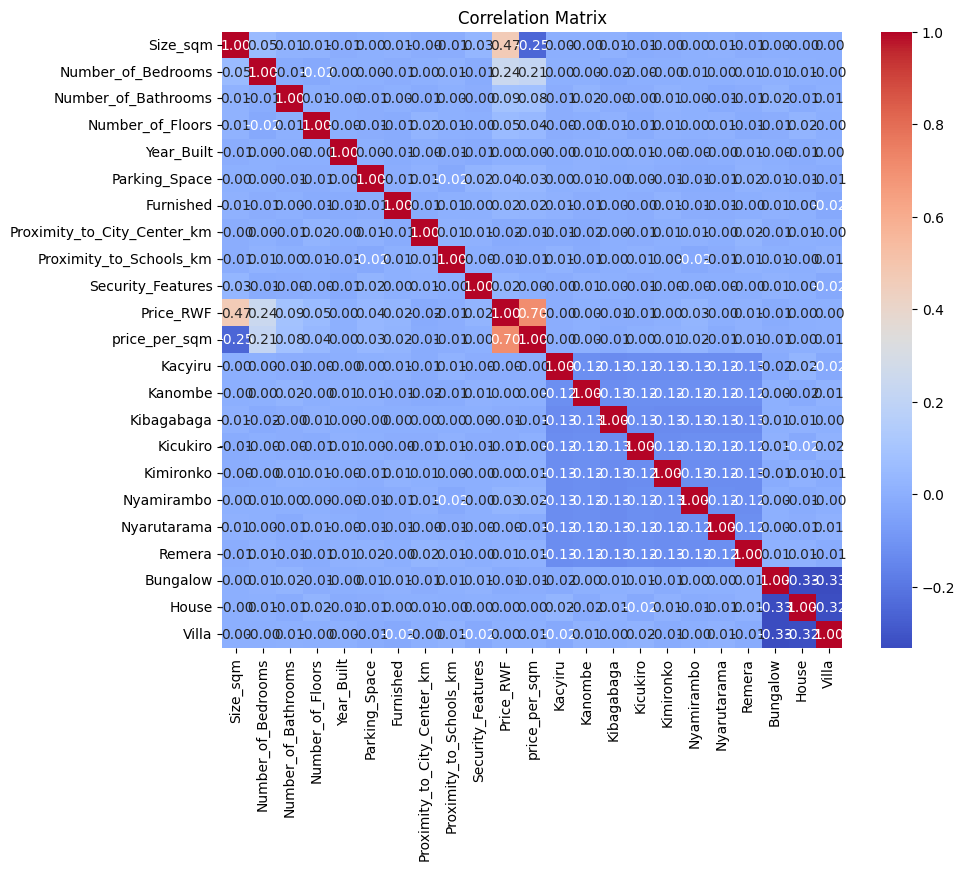

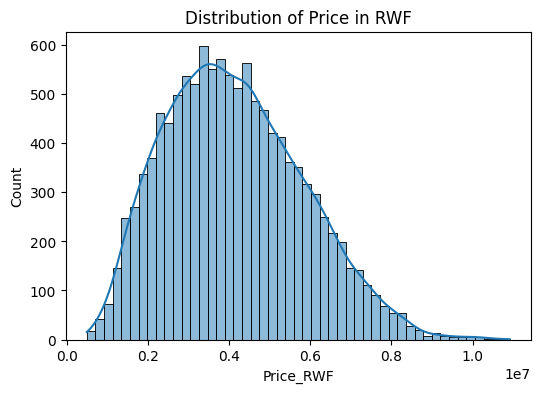

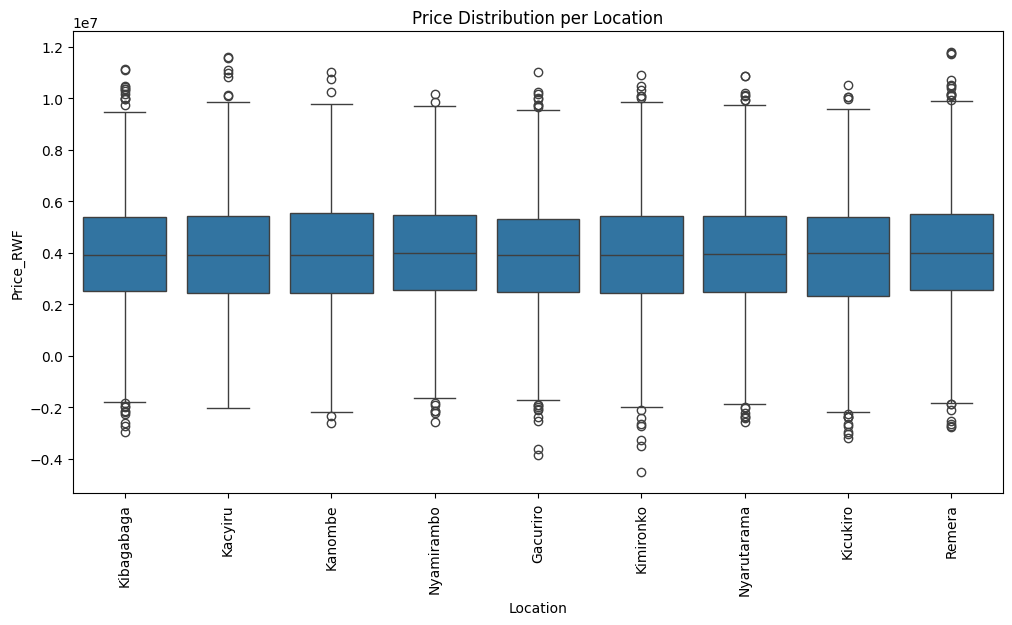

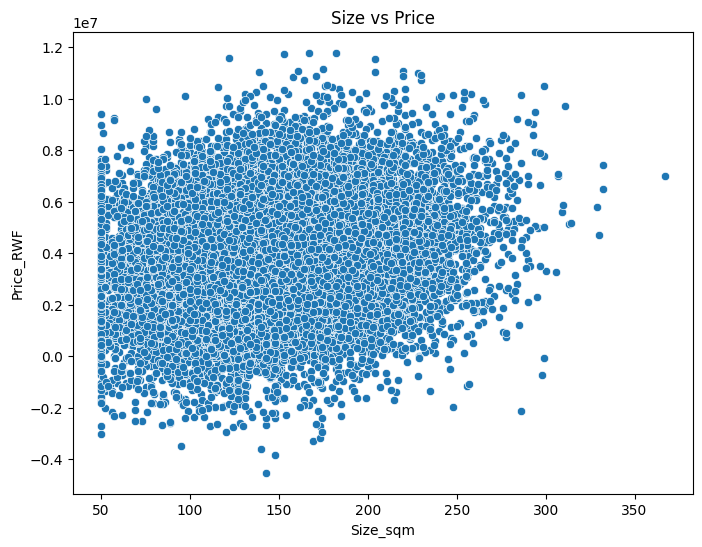

In [11]:
import seaborn as sns

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_final.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Distribution of target variable (Price_RWF)
plt.figure(figsize=(6, 4))
sns.histplot(df_final['Price_RWF'], kde=True)
plt.title('Distribution of Price in RWF')
plt.show()

# Price distribution per Location
plt.figure(figsize=(12, 6))
sns.boxplot(x='Location', y='Price_RWF', data=df1)
plt.xticks(rotation=90)
plt.title('Price Distribution per Location')
plt.show()

# Scatter plot of Size_sqm vs Price_RWF
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Size_sqm', y='Price_RWF', data=df1)
plt.title('Size vs Price')
plt.show()


In [12]:
# Dependent Variables
X = df_final.drop('Price_RWF', axis=1)
# Independent Variables
y = df_final['Price_RWF']

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Build 5-Layer Neural Network

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD  # Import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import numpy as np

# Scale features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale the target values (important for regression problems with large outputs)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

# Create a simplified neural network model with fewer layers
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# Second hidden layer
model.add(Dense(32, activation='relu'))

# Output layer (single output for regression)
model.add(Dense(1))

# Adjust optimizer to SGD with a lower learning rate
optimizer = SGD(learning_rate=0.001, momentum=0.9)  # Change to SGD
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping and scaled data
history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_test_scaled, y_test_scaled), 
                    epochs=50, batch_size=32, callbacks=[early_stopping])

# Predict on test data and inverse the scaling to get the original scale of the predictions
predictions_scaled = model.predict(X_test_scaled)
predictions = y_scaler.inverse_transform(predictions_scaled)




Epoch 1/50

296/296 [==============================] - 2s 5ms/step - loss: 0.3399 - val_loss: 0.1245
Epoch 2/50
296/296 [==============================] - 1s 3ms/step - loss: 0.0855 - val_loss: 0.0668
Epoch 3/50
296/296 [==============================] - 1s 3ms/step - loss: 0.0513 - val_loss: 0.0461
Epoch 4/50
296/296 [==============================] - 1s 3ms/step - loss: 0.0370 - val_loss: 0.0348
Epoch 5/50
296/296 [==============================] - 1s 3ms/step - loss: 0.0295 - val_loss: 0.0282
Epoch 6/50
296/296 [==============================] - 1s 3ms/step - loss: 0.0246 - val_loss: 0.0243
Epoch 7/50
296/296 [==============================] - 1s 4ms/step - loss: 0.0213 - val_loss: 0.0216
Epoch 8/50
296/296 [==============================] - 1s 3ms/step - loss: 0.0189 - val_loss: 0.0196
Epoch 9/50
296/296 [==============================] - 2s 7ms/step - loss: 0.0171 - val_loss: 0.0183
Epoch 10/50
296/296 [==============================] - 1s 4ms/step - loss: 0.0158 - val_loss: 0.0

In [14]:
# Print an example prediction for the first test example
print(f"Predicted price: {predictions[0][0]}")

# Use iloc to access the actual value from y_test
print(f"Actual price: {y_test.iloc[0]}")  # Use iloc instead of direct indexing


Predicted price: 5241398.5
Actual price: 5110424


Plot Training Loss and Validation Loss

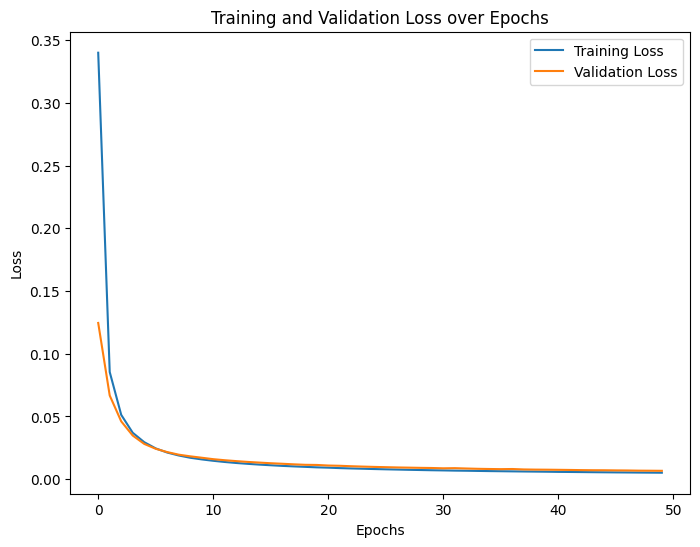

In [15]:
# Plotting the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Train with XGBoost Classifier

In [16]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Initialize the XGBoost Regressor
xgboost_model = XGBRegressor(n_estimators=100, learning_rate=0.1)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgboost_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2}")
print(f"Mean Squared Error: {mse}")


R² Score: 0.9992706219902504
Mean Squared Error: 2117614359.1837242


In [17]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)  # Ignore user warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)  # Ignore deprecation warnings

# Prediction function using the trained models
def predict_price(Location, Property_Type, Size_sqm, Number_of_Bedrooms, Number_of_Bathrooms, Number_of_Floors, Parking_Space):
    # Create an empty array for feature inputs
    x = np.zeros(len(X_train.columns))  # Assuming X_train is your training data
    
    # Set the corresponding feature values
    x[0] = Size_sqm
    x[1] = Number_of_Bedrooms
    x[2] = Number_of_Bathrooms
    x[3] = Number_of_Floors
    x[4] = Parking_Space
    
    # Set the location feature (assuming the location names are one-hot encoded columns in X)
    if Location in X_train.columns:
        loc_index = np.where(X_train.columns == Location)[0][0]
        x[loc_index] = 1
    
    # Set the property type feature (assuming property types are one-hot encoded)
    if Property_Type in X_train.columns:
        prop_index = np.where(X_train.columns == Property_Type)[0][0]
        x[prop_index] = 1
    
    # Scale the input features
    x_scaled = scaler.transform([x])  # Use the fitted scaler to transform the input
    
    # Neural Network Prediction (inverse the scaling of the output)
    neural_net_pred_scaled = model.predict(x_scaled)[0][0]  # Predict and get the scaled output
    neural_net_pred = y_scaler.inverse_transform([[neural_net_pred_scaled]])[0][0]  # Inverse scale to get original output
    
    # XGBoost Prediction (Assuming the model is trained and available)
    xgboost_pred = xgboost_model.predict(x_scaled)[0]  # XGBoost prediction doesn't need inverse scaling

    # Return the average prediction from both models
    return (neural_net_pred + xgboost_pred) / 2

# Example predictions
print(predict_price('Kibagabaga', 'Bungalow', 1000, 4, 2, 1, 1))
print(predict_price('Kibagabaga', 'Bungalow', 170, 1, 2, 1, 1))


1/1 [==============================] - 0s 91ms/step
14077789.731432373
1/1 [==============================] - 0s 32ms/step
4226285.824060368


In [18]:

import pickle
import json
# Save the trained models
with open('model_corrected_xgboost/kigali_model_neural_network.pickle', 'wb') as f:
    pickle.dump(model, f)

# Save the columns of the dataset for UI integration
columns = {'data_columns': [col.lower() for col in X.columns]}
with open("json_corrected_xgboost/columns.json", "w") as f:
    f.write(json.dumps(columns))